In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import itertools

In [15]:
# Set seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [16]:
# Directories
data_dirs = {"train": "dataset/train", "val": "dataset/validation", "test": "dataset/test"}

In [17]:
# Image properties
batch_size = 1
img_height, img_width = 500, 500

In [18]:
# Custom preprocessing function
def custom_preprocess(img):
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.grayscale_to_rgb(img)
    return tf.keras.applications.resnet50.preprocess_input(img)

In [19]:
# Data generators
data_gen = {
    phase: ImageDataGenerator(preprocessing_function=custom_preprocess)
    for phase in ["train", "val", "test"]
}

data_loaders = {
    phase: data_gen[phase].flow_from_directory(
        data_dirs[phase],
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=(phase == "train")
    )
    for phase in ["train", "val", "test"]
}

Found 569 images belonging to 4 classes.
Found 224 images belonging to 4 classes.
Found 145 images belonging to 4 classes.


In [20]:
# Model setup
num_classes = len(data_loaders["train"].class_indices)
base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(img_height, img_width, 3), pooling='avg', weights='imagenet')
for layer in base_model.layers[:int(0.70 * len(base_model.layers))]:
    layer.trainable = False

In [21]:
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(448, activation='relu', kernel_regularizer=l2(1e-5)),
    layers.Dense(240, activation='relu', kernel_regularizer=l2(1e-5)),
    layers.Dense(112, activation='relu', kernel_regularizer=l2(1e-5)),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 448)            │       917,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 240)            │       107,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 112)            │        26,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           452 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,640,868 (94.00 MB)

 Trainable params: 18,266,596 (69.68 MB)

 Non-trainable params: 6,374,272 (24.32 MB)

In [23]:
# Learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=5e-6, decay_steps=10000, decay_rate=0.9
)

# Optimizer
optimizer = Adam(learning_rate=lr_schedule)

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("models/best_model.keras", save_best_only=True, monitor="val_loss")

# Model Compilation
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [24]:
# Training
history = model.fit(
    data_loaders["train"],
    validation_data=data_loaders["val"],
    epochs=15,
    batch_size=1,  # Adjust based on memory
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 93s 123ms/step - accuracy: 0.4794 - loss: 1.2254 - val_accuracy: 0.5982 - val_loss: 0.9494
Epoch 2/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 70s 124ms/step - accuracy: 0.7728 - loss: 0.7398 - val_accuracy: 0.8795 - val_loss: 0.4918
Epoch 3/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 65s 114ms/step - accuracy: 0.9928 - loss: 0.3172 - val_accuracy: 0.9554 - val_loss: 0.2039
Epoch 4/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 71s 124ms/step - accuracy: 1.0000 - loss: 0.1279 - val_accuracy: 0.9643 - val_loss: 0.1301
Epoch 5/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 67s 117ms/step - accuracy: 1.0000 - loss: 0.0698 - val_accuracy: 0.9732 - val_loss: 0.1013
Epoch 6/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 66s 116ms/step - accuracy: 1.0000 - loss: 0.0379 - val_accuracy: 0.9732 - val_loss: 0.0957
Epoch 7/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 67s 118ms/step - accuracy: 1.0000 - loss: 0.0285 - val_accuracy: 0.9732 - val_loss: 0.0676
Epoch 8/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 68s 119ms/step - accuracy: 1.0000 - loss: 0

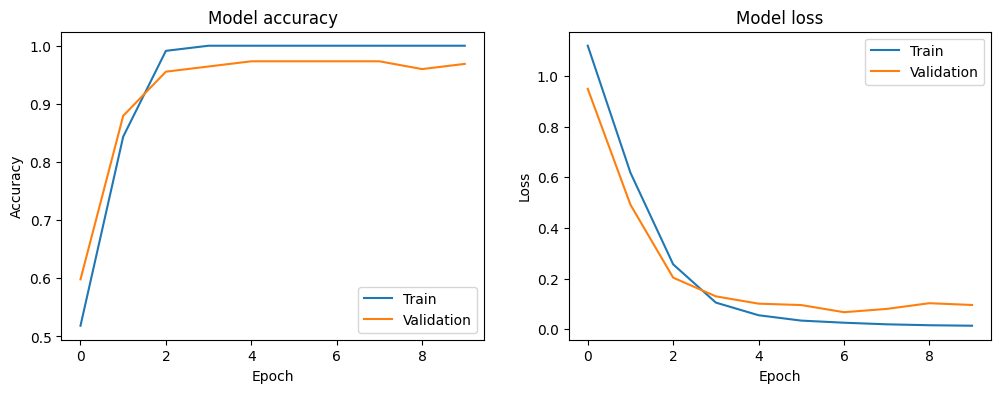

In [31]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))
for i, metric in enumerate(["accuracy", "loss"], 1):
    plt.subplot(1, 2, i)
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.title(f'Model {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend(['Train', 'Validation'])
plt.show()

In [32]:
# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━

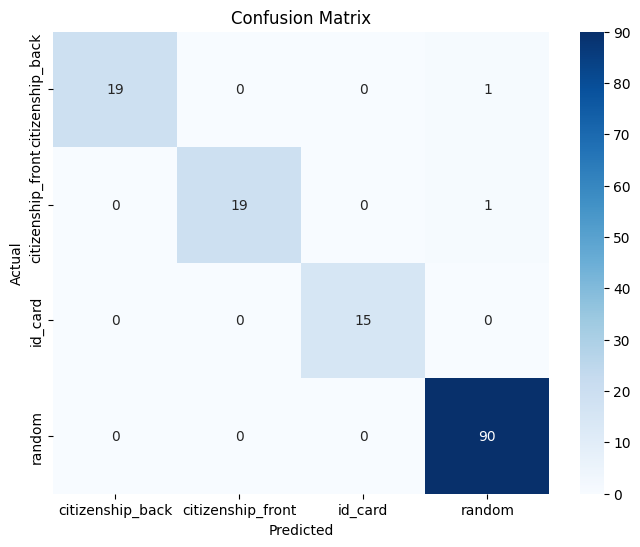

                   precision    recall  f1-score   support

 citizenship_back       1.00      0.95      0.97        20
citizenship_front       1.00      0.95      0.97        20
          id_card       1.00      1.00      1.00        15
           random       0.98      1.00      0.99        90

         accuracy                           0.99       145
        macro avg       0.99      0.97      0.98       145
     weighted avg       0.99      0.99      0.99       145



In [33]:
# Evaluate on test set
y_true, y_pred = [], []
for _ in range(len(data_loaders["test"])):
    x, y = next(data_loaders["test"])
    y_true.append(np.argmax(y))
    y_pred.append(np.argmax(model.predict(x)))

plot_confusion_matrix(y_true, y_pred, list(data_loaders["test"].class_indices.keys()))
print(classification_report(y_true, y_pred, target_names=list(data_loaders["test"].class_indices.keys())))

In [34]:
# Load model
model = tf.keras.models.load_model("models/best_model.keras")

# Learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=2e-5, decay_steps=10000, decay_rate=0.9
)

# Optimizer
optimizer = Adam(learning_rate=lr_schedule)

# Model Compilation
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [35]:
# Inference Code
def load_and_predict(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.image.rgb_to_grayscale(img_array)
    img_array = tf.image.grayscale_to_rgb(img_array)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)
    class_probabilities = prediction[0]
    print(class_probabilities)
    predicted_class = np.argmax(prediction, axis=1)[0]
    
    plt.imshow(img)
    plt.title(f"Predicted: {list(data_loaders['test'].class_indices.keys())[predicted_class]}")
    plt.axis('off')
    plt.show()
    return list(data_loaders['test'].class_indices.keys())[predicted_class]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
[5.32842591e-07 1.00395504e-04 9.99830246e-01 6.88668952e-05]


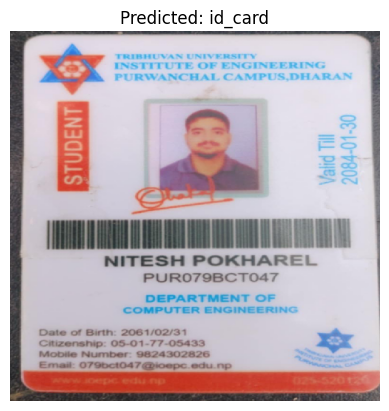

In [42]:
# Example usage:
predicted_label = load_and_predict("dataset/check_image/id.png")